Перші 5 записів датасету:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Інформація про датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  -

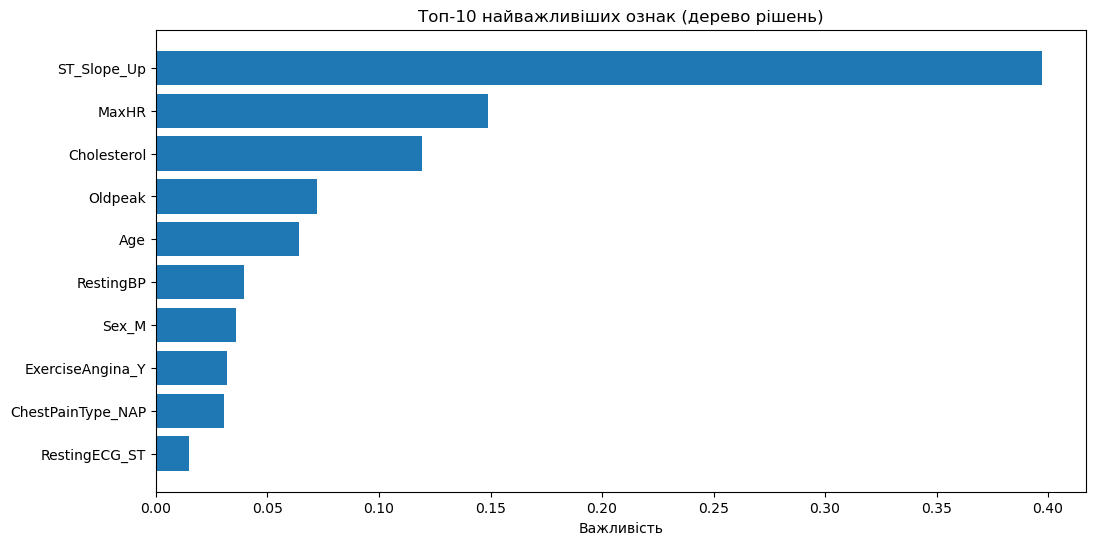



Порівняння гомогенних ансамблів:


Voting (5 trees):
Accuracy: 0.8514
F1-score: 0.8656

Stacking (3 trees):
Accuracy: 0.8551
F1-score: 0.8718

Bagging (10 trees):
Accuracy: 0.8623
F1-score: 0.8782


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# 1. Завантаження та підготовка даних
try:
    # Завантаження датасету
    df = pd.read_csv('heart.csv')
    
    # Перевірка структури даних
    print("Перші 5 записів датасету:")
    print(df.head())
    
    print("\nІнформація про датасет:")
    print(df.info())
    
    # Визначення цільової змінної (HeartDisease)
    if 'HeartDisease' not in df.columns:
        target_col = [col for col in df.columns if 'heart' in col.lower() or 
                     'disease' in col.lower() or 'target' in col.lower()]
        if target_col:
            df = df.rename(columns={target_col[0]: 'HeartDisease'})
        else:
            df = df.rename(columns={df.columns[-1]: 'HeartDisease'})
    
    # Обробка категоріальних змінних
    categorical_cols = df.select_dtypes(include=['object']).columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    # Розділення на ознаки та цільову змінну
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']
    
    # Розділення на тренувальний та тестовий набори
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Стандартизація даних
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

except Exception as e:
    print(f"\nПомилка при завантаженні даних: {e}")
    exit()

# 2. Одиночні моделі (дерева рішень з різними параметрами)
print("\n" + "="*50)
print("\nОцінка одиночних моделей (дерева рішень):")
print("\n" + "="*50)

# Ініціалізація різних дерев рішень
trees = {
    'Tree (max_depth=3)': DecisionTreeClassifier(max_depth=3, random_state=42),
    'Tree (max_depth=5)': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Tree (unlimited)': DecisionTreeClassifier(max_depth=None, random_state=42),
    'Tree (min_samples_leaf=5)': DecisionTreeClassifier(min_samples_leaf=5, random_state=42),
    'Tree (max_features=sqrt)': DecisionTreeClassifier(max_features='sqrt', random_state=42)
}

# Навчання та оцінка кожного дерева
for name, tree in trees.items():
    tree.fit(X_train, y_train)
    pred = tree.predict(X_test)
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy_score(y_test, pred):.4f}")
    print(f"F1-score: {f1_score(y_test, pred):.4f}")

# 3. Гомогенні ансамблеві моделі (тільки дерева рішень)
print("\n" + "="*50)
print("\nГомогенні ансамблеві моделі (дерева рішень):")
print("\n" + "="*50)

# 3.1. Voting Classifier з різними деревами
voting_trees = VotingClassifier(
    estimators=[
        ('tree1', trees['Tree (max_depth=3)']),
        ('tree2', trees['Tree (max_depth=5)']),
        ('tree3', trees['Tree (unlimited)']),
        ('tree4', trees['Tree (min_samples_leaf=5)']),
        ('tree5', trees['Tree (max_features=sqrt)'])
    ],
    voting='soft'
)
voting_trees.fit(X_train, y_train)
voting_pred = voting_trees.predict(X_test)
print("\nVoting Classifier (5 різних дерев):")
print(f"Accuracy: {accuracy_score(y_test, voting_pred):.4f}")
print(f"F1-score: {f1_score(y_test, voting_pred):.4f}")

# 3.2. Stacking Classifier з деревами
stacking_trees = StackingClassifier(
    estimators=[
        ('tree1', trees['Tree (max_depth=3)']),
        ('tree2', trees['Tree (max_depth=5)']),
        ('tree3', trees['Tree (unlimited)'])
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42)
)
stacking_trees.fit(X_train, y_train)
stacking_pred = stacking_trees.predict(X_test)
print("\nStacking Classifier (3 дерева + логістична регресія):")
print(f"Accuracy: {accuracy_score(y_test, stacking_pred):.4f}")
print(f"F1-score: {f1_score(y_test, stacking_pred):.4f}")

# 3.3. Bagging з деревами 
from sklearn.ensemble import BaggingClassifier

bagging_tree = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=10,
    random_state=42
)
bagging_tree.fit(X_train, y_train)
bagging_pred = bagging_tree.predict(X_test)
print("\nBagging Classifier (10 дерев з max_depth=5):")
print(f"Accuracy: {accuracy_score(y_test, bagging_pred):.4f}")
print(f"F1-score: {f1_score(y_test, bagging_pred):.4f}")

# 4. Оптимізація гомогенного ансамблю
print("\n" + "="*50)
print("\nОптимізація гомогенного Voting ансамблю:")
print("\n" + "="*50)

# Параметри для GridSearch
param_grid = {
    'voting': ['soft', 'hard'],
    'weights': [
        [1, 1, 1, 1, 1],  # всі однакові
        [2, 1, 1, 1, 1],   # більша вага для першого дерева
        [1, 2, 1, 1, 1],   # більша вага для другого дерева
        [1, 1, 2, 1, 1]    # більша вага для третього дерева
    ]
}

grid_search = GridSearchCV(
    estimator=voting_trees,
    param_grid=param_grid,
    cv=5,
    scoring='f1'
)
grid_search.fit(X_train, y_train)

print("\nНайкращі параметри:", grid_search.best_params_)
print("Найкращий F1-score:", grid_search.best_score_)

# 5. Важливість ознак для найкращого дерева
print("\n" + "="*50)
print("\nАналіз важливості ознак для найкращого дерева:")
print("\n" + "="*50)

# Використаємо дерево з необмеженою глибиною
best_tree = trees['Tree (unlimited)']
best_tree.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_tree.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nВажливість ознак для дерева:")
print(feature_importance.head(10))

# Візуалізація
plt.figure(figsize=(12, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel('Важливість')
plt.title('Топ-10 найважливіших ознак (дерево рішень)')
plt.gca().invert_yaxis()
plt.show()

# 6. Порівняння всіх гомогенних ансамблів
print("\n" + "="*50)
print("\nПорівняння гомогенних ансамблів:")
print("\n" + "="*50)

ensemble_results = {
    'Voting (5 trees)': voting_trees,
    'Stacking (3 trees)': stacking_trees,
    'Bagging (10 trees)': bagging_tree
}

for name, model in ensemble_results.items():
    pred = model.predict(X_test)
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy_score(y_test, pred):.4f}")
    print(f"F1-score: {f1_score(y_test, pred):.4f}")